# Produce lifetime and geometrical XY maps

<i>
This notebook takes a clean kDST, measures the lifetime at
different points of the XY plane, performs the lifetime
correction and measures the energy at different points
of the XY plane. Both maps are stored in the same output
file.
</i>

### Notebook configuration

In [1]:
run_number                 = 4730
input_dst_filename         = f"$IC_DATA/Kr/dst_{run_number}_filtered.root.h5"
output_correction_filename = f"$IC_DATA/XYmaps/corrections_run{run_number}.h5"

Zrange  =   50,  550
XYrange = -200,  200
Erange  =  4e3, 14e3
Znbins  =   10
XYnbins =   60
Enbins  =   50

# Plotting style
default_cmap = "viridis"
figure_size  = 16, 12
font_size    = 15

### Imports

In [2]:
import os
import time
import collections

import tables            as tb
import numpy             as np
import matplotlib.pyplot as plt

import invisible_cities.core.fit_functions as fitf
import invisible_cities.reco.dst_functions as dstf
import invisible_cities.io  .kdst_io       as kdstio

from invisible_cities.core .core_functions import in_range
from invisible_cities.icaro.hst_functions  import display_matrix
from invisible_cities.icaro.hst_functions  import shift_to_bin_centers
from invisible_cities.icaro.hst_functions  import measurement_string
from invisible_cities.icaro.hst_functions  import labels

%matplotlib inline

### Initialization

In [3]:
Zbins     = np.linspace(* Zrange,  Znbins+1)
Ebins     = np.linspace(* Erange,  Enbins+1)
XYbins    = np.linspace(*XYrange, XYnbins+1)
XYcenters = shift_to_bin_centers(XYbins)
XYpitch   = np.diff(XYbins)[0]

input_dst_filename         = os.path.expandvars(        input_dst_filename)
output_correction_filename = os.path.expandvars(output_correction_filename)
output_correction_filename = output_correction_filename.replace(".h5", "_{XYpitch}mm.h5")

plt.rcParams["figure.figsize"] = figure_size
plt.rcParams[  "font.size"   ] =   font_size

### Read data

In [4]:
dst           = dstf.load_dst(input_dst_filename, "DST", "Events")
unique_events = ~dst.event.duplicated()

number_of_S2s_full  = np.size         (unique_events)
number_of_evts_full = np.count_nonzero(unique_events)

print(f"Total number of S2s   : {number_of_S2s_full} ")
print(f"Total number of events: {number_of_evts_full}")

Total number of S2s   : 494584 
Total number of events: 492573


In [5]:
X  = dst.X  .values
Y  = dst.Y  .values
Z  = dst.Z  .values
E0 = dst.S2e.values

### Event distribution

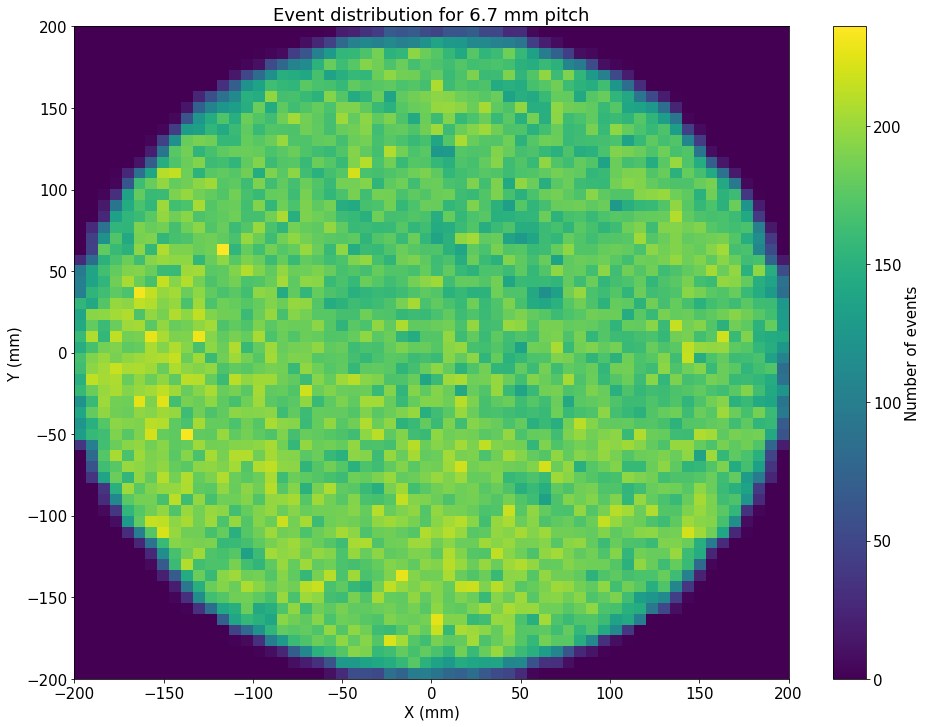

In [6]:
nevt, *_ = plt.hist2d(X, Y, (XYbins, XYbins))
plt.colorbar().set_label("Number of events")
labels("X (mm)", "Y (mm)", f"Event distribution for {XYpitch:.1f} mm pitch")

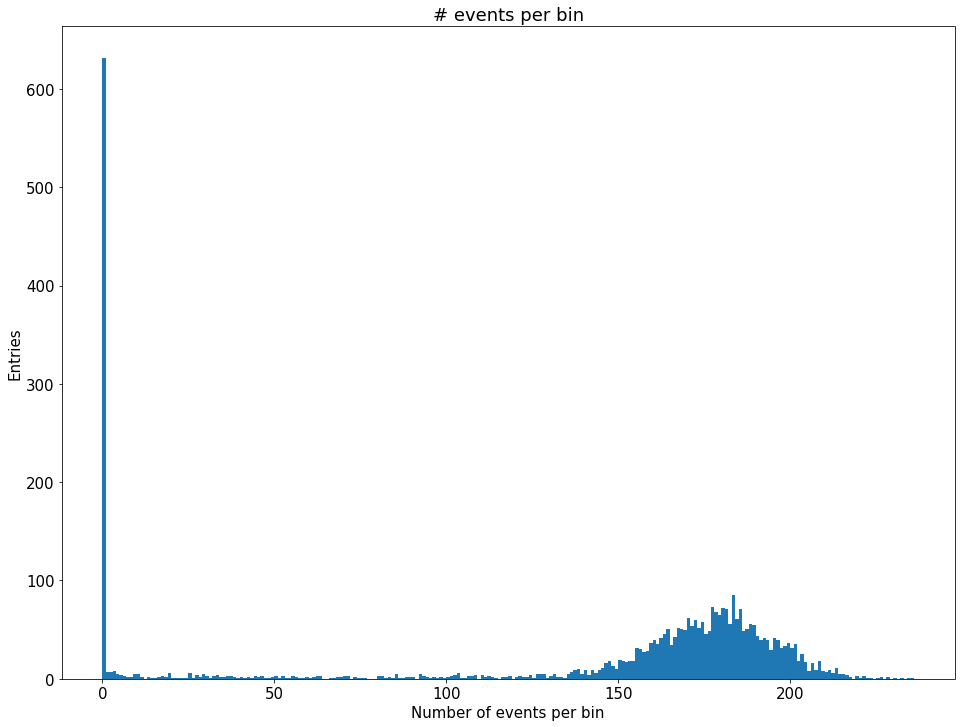

In [7]:
nevt_max = int(np.max(nevt))
plt.hist(nevt.flatten(), nevt_max, (0, nevt_max))
labels("Number of events per bin", "Entries", "# events per bin")

### Lifetime map

In [8]:
Escale  = np.zeros((XYnbins, XYnbins), dtype=np.double)
Escaleu = np.zeros((XYnbins, XYnbins), dtype=np.double)
LT      = np.zeros((XYnbins, XYnbins), dtype=np.double)
LTu     = np.zeros((XYnbins, XYnbins), dtype=np.double)

for i, (xmin, xmax) in enumerate(zip(XYbins[:-1], XYbins[1:])):
    for j, (ymin, ymax) in enumerate(zip(XYbins[:-1], XYbins[1:])):
        sel_x = in_range(X, xmin, xmax)
        sel_y = in_range(Y, ymin, ymax)
        sel   = sel_x & sel_y

        # Discard low stat bins
        if np.count_nonzero(sel) < 100: continue

        x, y, yu     = fitf.profileX(Z[sel], E0[sel], Znbins, Zrange)
        valid_points = yu > 0

        x  = x [valid_points]
        y  = y [valid_points]
        yu = yu[valid_points]

        ymax = np.max(y)
        seed = ymax, ymax * np.sum(np.diff(x)) / np.sum(np.diff(y))
        f    = fitf.fit(fitf.expo, x, y, seed, sigma=yu)

        assert np.all(f.values != seed)

        Escale [i,j] =  f.values[0]
        LT     [i,j] = -f.values[1]
        Escaleu[i,j] =  f.errors[0]/f.values[0] * 100 # relative uncertainty in percent
        LTu    [i,j] = -f.errors[1]/f.values[1] * 100 # relative uncertainty in percent

In [9]:
lt_valid = LT > 100

lt_mean  = np.mean(LT [lt_valid])
lt_std   = np.std (LT [lt_valid])
ltu_mean = np.mean(LTu[lt_valid])
ltu_std  = np.std (LTu[lt_valid])

E_mean  = np.mean(Escale [lt_valid])
E_std   = np.std (Escale [lt_valid])
Eu_mean = np.mean(Escaleu[lt_valid])
Eu_std  = np.std (Escaleu[lt_valid])


# This is to avoid the effect of low stat bins
# to the map. Data points in that bin could be
# loss or corrected with a ridiculous lifetime.
# Thus, we assign the average value. This works
# because correcting with a slightly different
# lifetime does not have a big impact on energy
# resolution.
LT_safe  = LT.copy()
LT_safe [~lt_valid] = lt_mean

LTu_safe = LTu.copy()
LTu_safe[~lt_valid] = ltu_mean

Average lifetime             (mean +- rms) = (1761 +- 85) µs
Average lifetime uncertainty (mean +- rms) = (2.23 +- 0.68) %


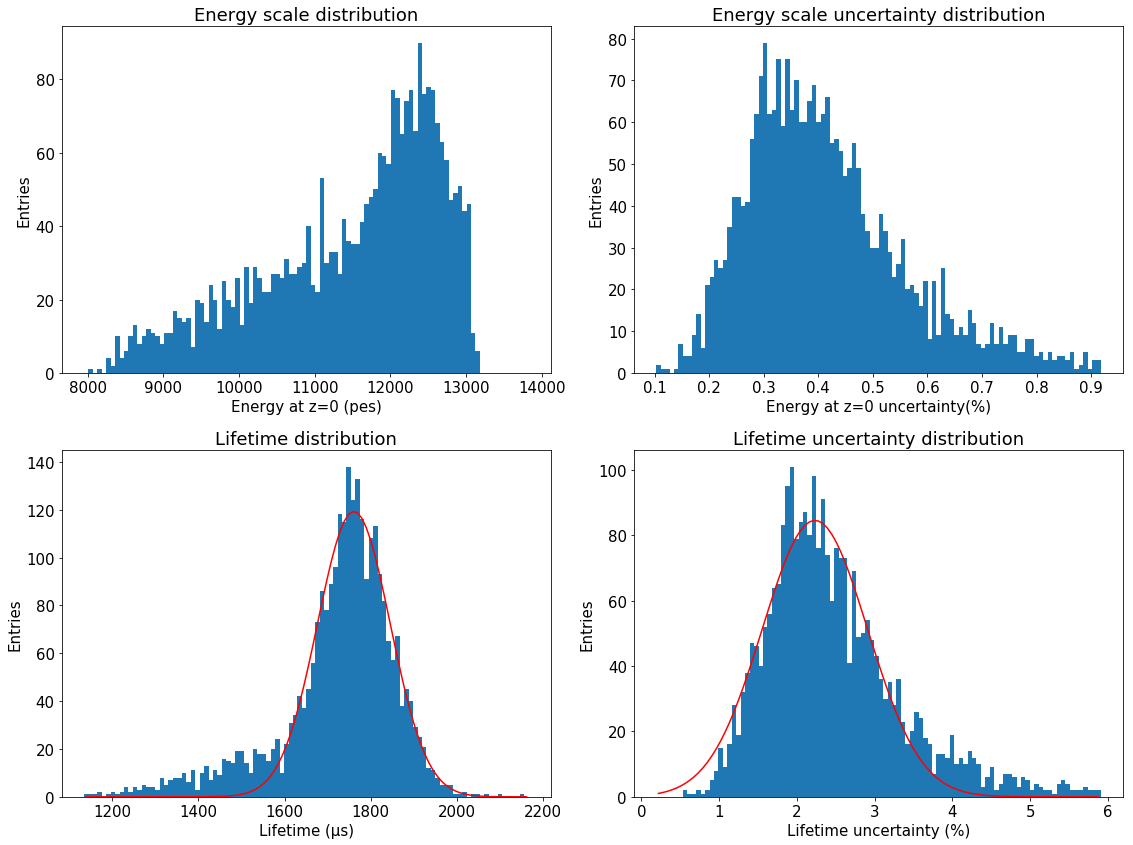

In [10]:
plt.subplot(2, 2, 1)
y, x, _ = plt.hist(Escale.flatten(), 100, (E_mean - 3*E_std,
                                           E_mean + 2*E_std))
labels("Energy at z=0 (pes)", "Entries", "Energy scale distribution")

plt.subplot(2, 2, 2)
y, x, _ = plt.hist(Escaleu.flatten(), 100, (Eu_mean - 1.5*Eu_std,
                                            Eu_mean + 2.0*Eu_std))
labels("Energy at z=0 uncertainty(%)", "Entries", "Energy scale uncertainty distribution")

plt.subplot(2, 2, 3)
y, x, _ = plt.hist(LT.flatten(), 100, (lt_mean - 4*lt_std,
                                       lt_mean + 3*lt_std))
x    = shift_to_bin_centers(x)
seed = 1e3, x[np.argmax(y)], 10
f    = fitf.fit(fitf.gauss, x, y, seed)
plt.plot(x, f.fn(x), "r-")
labels("Lifetime (µs)", "Entries", "Lifetime distribution")

print("Average lifetime             (mean +- rms) = ({}) µs".format(measurement_string(f.values[1], f.values[2])))


plt.subplot(2, 2, 4)
y, x, _ = plt.hist(LTu.flatten(), 100, (ltu_mean - 1.5*ltu_std,
                                        ltu_mean + 2.0*ltu_std))
x    = shift_to_bin_centers(x)
seed = 1e3, x[np.argmax(y)], 10
f    = fitf.fit(fitf.gauss, x, y, seed)
plt.plot(x, f.fn(x), "r-")
labels("Lifetime uncertainty (%)", "Entries", "Lifetime uncertainty distribution")

print("Average lifetime uncertainty (mean +- rms) = ({}) %".format(measurement_string(f.values[1], f.values[2])))

plt.tight_layout()

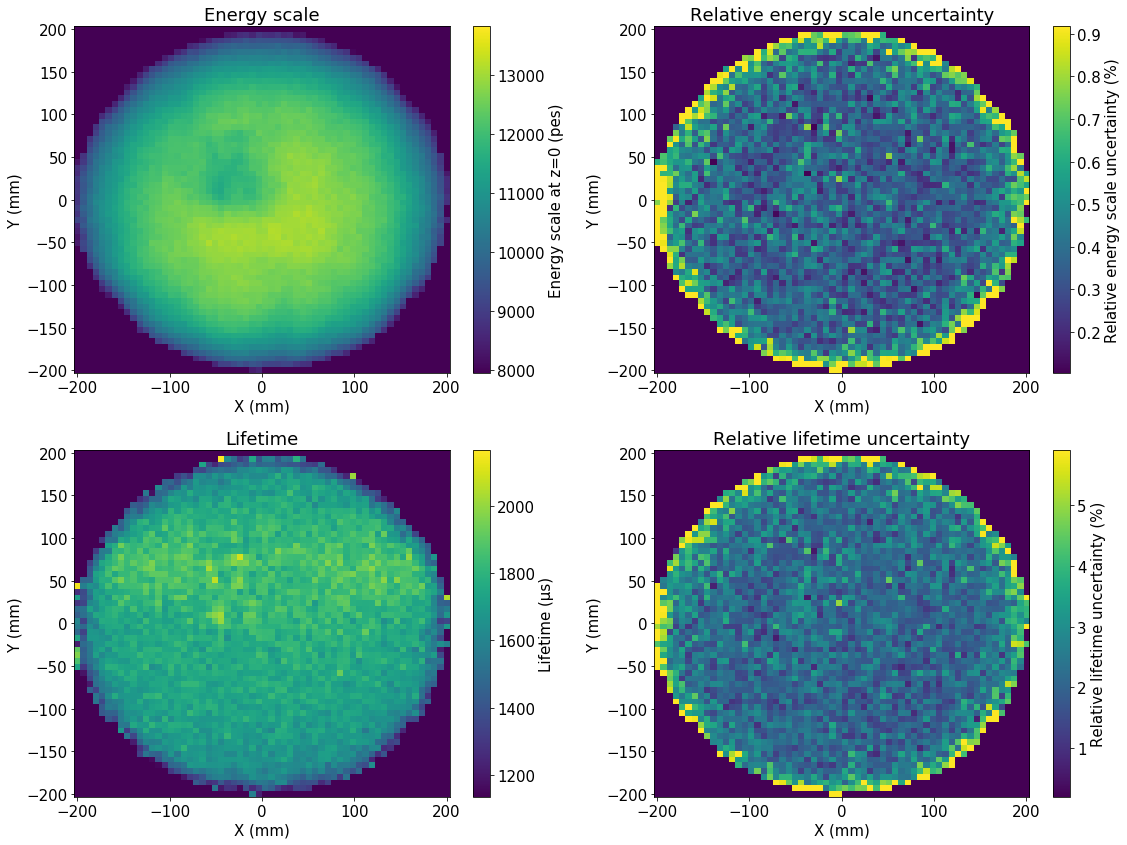

In [11]:
plt.subplot(2, 2, 1)
*_, cb = display_matrix(XYcenters, XYcenters, Escale,
                        vmin = E_mean - 3*E_std,
                        vmax = E_mean + 2*E_std,
                        cmap = default_cmap,
                        new_figure = False);
cb.set_label("Energy scale at z=0 (pes)")
labels("X (mm)", "Y (mm)", "Energy scale")

plt.subplot(2, 2, 2)
*_, cb = display_matrix(XYcenters, XYcenters, Escaleu,
                        vmin = Eu_mean - 1.5*Eu_std,
                        vmax = Eu_mean + 2.0*Eu_std,
                        cmap = default_cmap,
                        new_figure = False);
cb.set_label("Relative energy scale uncertainty (%)")
labels("X (mm)", "Y (mm)", "Relative energy scale uncertainty")

plt.subplot(2, 2, 3)
*_, cb = display_matrix(XYcenters, XYcenters, LT,
                        vmin = lt_mean - 4*lt_std,
                        vmax = lt_mean + 3*lt_std,
                        cmap = default_cmap,
                        new_figure = False);
cb.set_label("Lifetime (µs)")
labels("X (mm)", "Y (mm)", "Lifetime")

plt.subplot(2, 2, 4)
*_, cb = display_matrix(XYcenters, XYcenters, LTu,
                        vmin = ltu_mean - 1.5*ltu_std,
                        vmax = ltu_mean + 2.0*ltu_std,
                        cmap = default_cmap,
                        new_figure = False);
cb.set_label("Relative lifetime uncertainty (%)")
labels("X (mm)", "Y (mm)", "Relative lifetime uncertainty")

plt.tight_layout()

In [12]:
with tb.open_file(output_correction_filename, "w") as f:
    write = kdstio.xy_lifetime_writer(f)#, group = "XYcorrections", table_name = "Lifetime")
    write(XYcenters, XYcenters, LT_safe, LTu_safe, nevt)

### Geometry map

In [13]:
Zcorrection = dstf.load_lifetime_xy_corrections(output_correction_filename)

Ez = E0 * Zcorrection(Z, X, Y).value

In [14]:
x, y, Eave, Eaveu = fitf.profileXY(X, Y, Ez, XYnbins, XYnbins, XYrange, XYrange)

eave_valid = Eave > 1000
Eaveu[ eave_valid] /= Eave[eave_valid] # Relative uncertainty
Eaveu[ eave_valid] *= 100              # In percent
Eaveu[~eave_valid]  = 0

Eave_mean  = np.mean(Eave [eave_valid])
Eave_std   = np.std (Eave [eave_valid])
Eaveu_mean = np.mean(Eaveu[eave_valid])
Eaveu_std  = np.std (Eaveu[eave_valid])

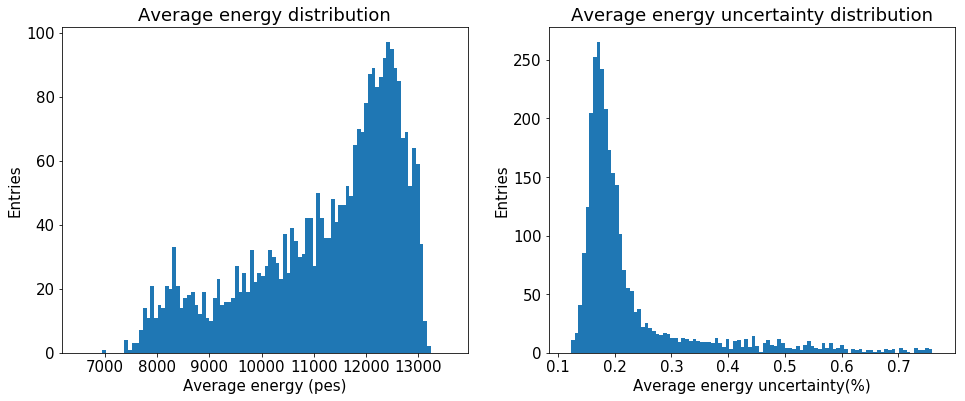

In [15]:
plt.figure(figsize=(figure_size[0], figure_size[1]/2))

plt.subplot(1, 2, 1)
plt.hist(Eave.flatten(), 100, (Eave_mean - 4*E_std,
                               Eave_mean + 2*E_std))
labels("Average energy (pes)", "Entries", "Average energy distribution")

plt.subplot(1, 2, 2)
plt.hist(Eaveu.flatten(), 100, (Eaveu_mean - 0.5*Eaveu_std,
                                Eaveu_mean + 1.5*Eaveu_std))
labels("Average energy uncertainty(%)", "Entries", "Average energy uncertainty distribution")

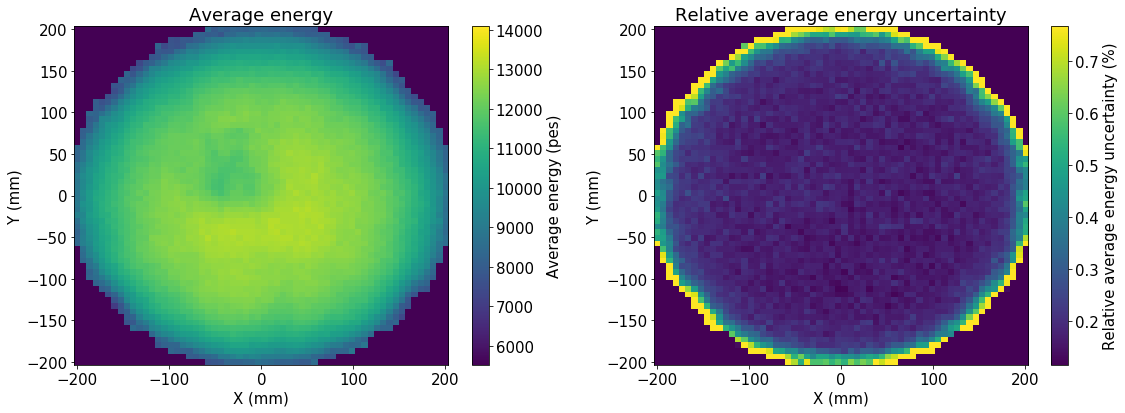

In [16]:
plt.figure(figsize=(figure_size[0], figure_size[1]/2))
plt.subplot(1, 2, 1)
*_, cb = display_matrix(x, y, Eave,
                        vmin = Eave_mean - 4*Eave_std,
                        vmax = Eave_mean + 2*Eave_std,
                        cmap = default_cmap,
                        new_figure=False);
cb.set_label("Average energy (pes)")
labels("X (mm)", "Y (mm)", "Average energy")

plt.subplot(1, 2, 2)
*_, cb = display_matrix(x, y, Eaveu,
                        vmin = Eaveu_mean - 0.5*Eaveu_std,
                        vmax = Eaveu_mean + 1.5*Eaveu_std,
                        cmap = default_cmap,
                        new_figure=False);
cb.set_label("Relative average energy uncertainty (%)")
labels("X (mm)", "Y (mm)", "Relative average energy uncertainty")

plt.tight_layout()

In [17]:
with tb.open_file(output_correction_filename, "r+") as f:
    write = kdstio.xy_correction_writer(f)#, group = "XYcorrections", table_name = "Lifetime")
    write(XYcenters, XYcenters, Eave, Eaveu, nevt)

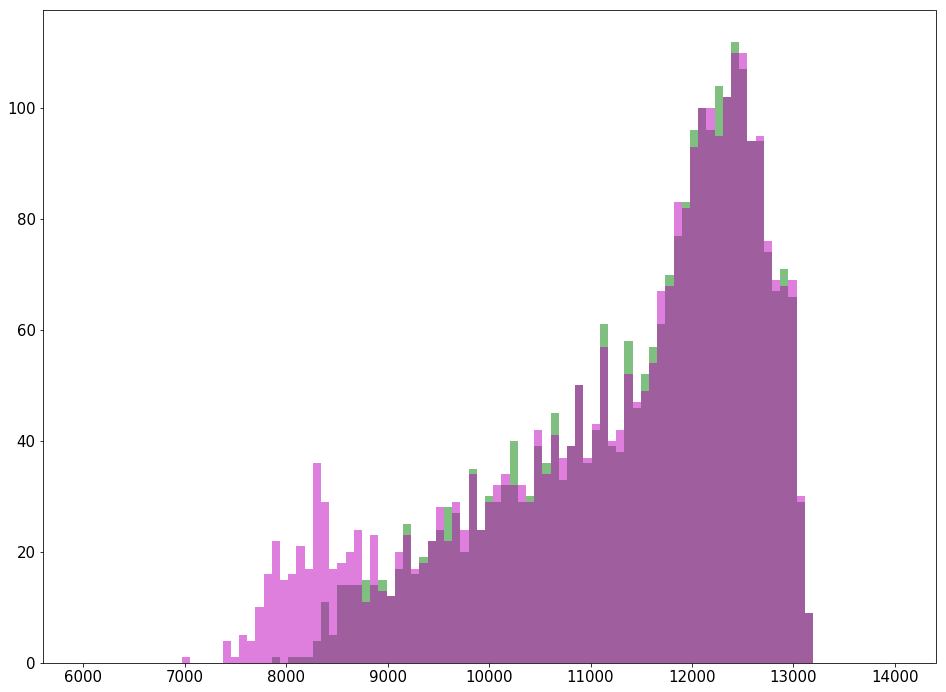

In [25]:
bins = np.linspace(6e3, 14e3, 100)
plt.hist(Escale.flatten(), bins, alpha=0.5, color="g")
plt.hist(Eave  .flatten(), bins, alpha=0.5, color="m");

In [21]:
where = (Eaveu > 0) & (Escaleu > 0)
pull = (Eave - Escale)/(Eaveu**2 + Escaleu**2)**0.5

/Applications/anaconda3/envs/IC3.6/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  
/Applications/anaconda3/envs/IC3.6/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


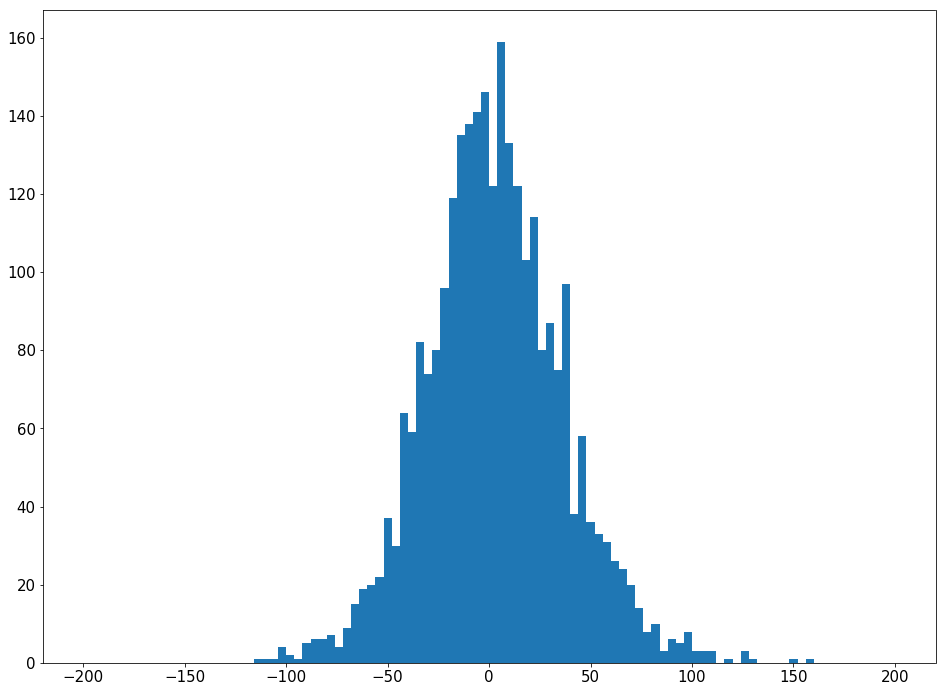

In [22]:
plt.hist(pull[where].flatten(), 100, (-200, 200));

In [54]:
pull = (Eave - Escale)/(Eaveu**2 + Escaleu**2)**0.5

np.nanmax(pull)

/Applications/anaconda3/envs/IC3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


18114.977041602127

/Applications/anaconda3/envs/IC3.6/lib/python3.6/site-packages/numpy/lib/function_base.py:748: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= mn)
/Applications/anaconda3/envs/IC3.6/lib/python3.6/site-packages/numpy/lib/function_base.py:749: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= mx)


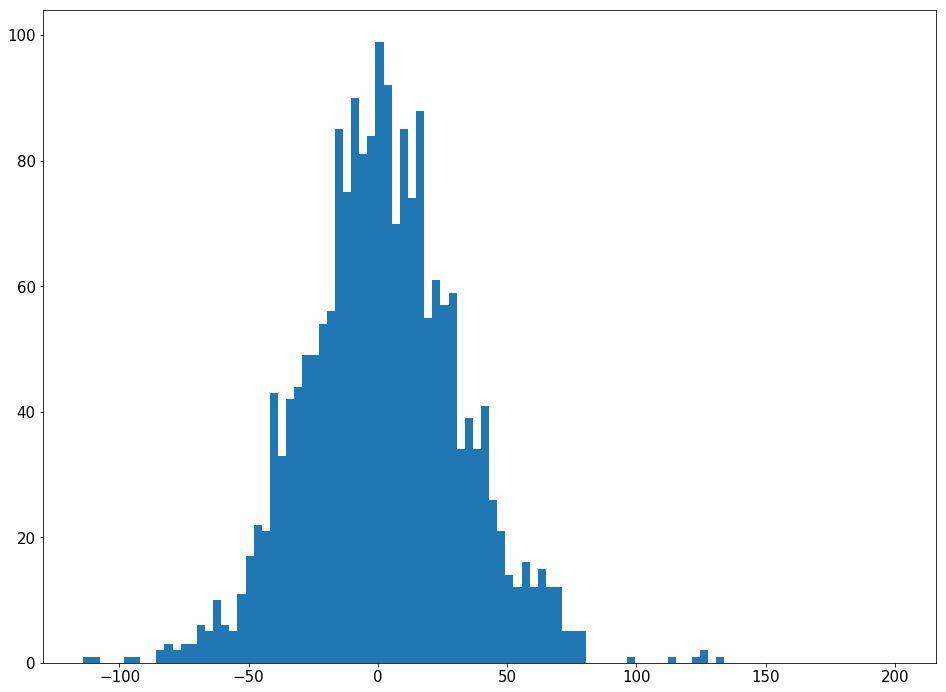

In [55]:
plt.hist(pull.flatten(), 100, (np.nanmin(pull), 200));

/Applications/anaconda3/envs/IC3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


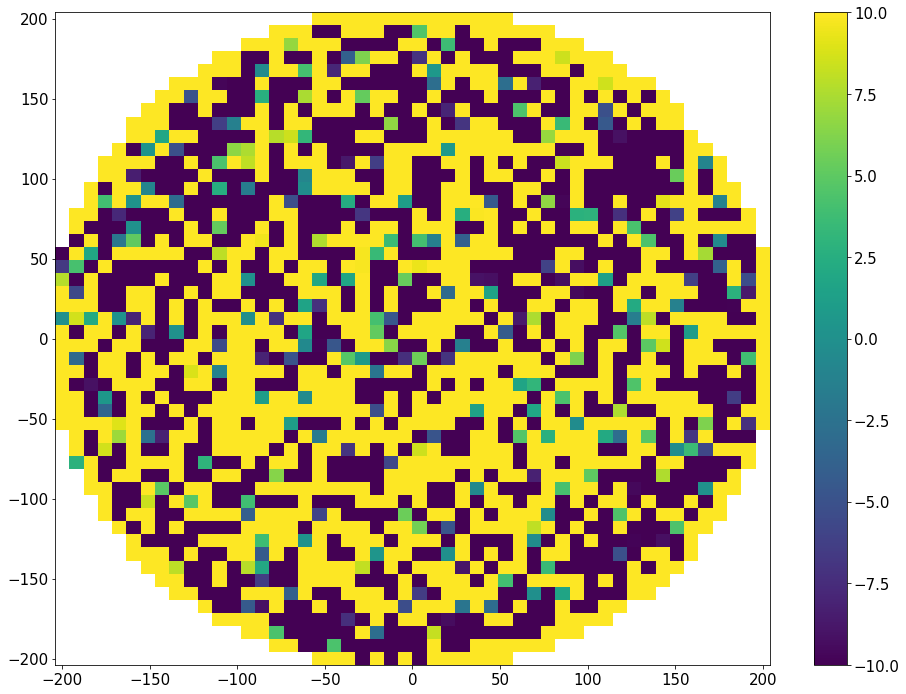

In [43]:
display_matrix(x, y, (Eave - Escale)/Eaveu,
               vmin = -10, vmax=10);